# Lane Detection using OpenCV

In [4]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
import os
import json
import time
import yaml

## Configuration

In [173]:
class Line():

  def __init__(self):

    ''' validation image '''
    ln_id = None # segmenation line id
    bd_id = None # segmenation border id

    ''' set variables '''
    self.set_ln_vars()

  def set_ln_rating(self):
    ''' set or reset rating variables '''

    self.r_border = 0 # rating border
    self.r_iou = 0 # rating intersection over union
    self.r_len = 0 # rating length
    self.r_total = 0 # total rating
  
  def set_ln_vars(self):
    ''' set or rset variables '''

    ''' polyfit '''
    self.fit = None # polyfit
    self.prevfit = None # previous polyfit
    self.polypix = None # x-y-coord polyfit

    ''' gradient 1st order polyfit '''
    self.grad = None 

    ''' plotting '''
    self.winco = None # ((x1,y1),(x2,y2)) window coordinates
    self.winpx = None # pixel bordered by windows

    ''' base '''
    self.xbase = None # start base of the line

    ''' quality rating '''
    self.set_ln_rating()


def set_images(self):
  ''' set or reset images '''

  self.im_input = None # input image
  self.im_canny = None # result canny edge detection
  self.im_range = None # result color range
  self.im_warped = None # birds eye view transformed
  self.im_bwarped = None # binaray warped
  self.im_hist = None # histogram
  self.im_polyfit = None # result polyfit search
  self.im_win = None # result sliding window search
  self.im_gt = None # ground trith visualization
  self.im_masked = None # engine hood removed
  self.im_prep = None # im_masked + croped

def decl_variables(self):

  ''' images '''
  set_images(self)
  self.im_val = None # validation image semantic map
  self.im_rating = None # quality rating visualization 
  self.im_match = None # match between predicted and preprocessed line
  self.dyn_mask = None # dynamic mask from previous detection

  ''' line '''
  self.ll = Line() # left line
  self.rl = Line() # right line
  self.lns = [self.ll, self.rl] # lines

  ''' vehicle control '''
  self.prev_ofst_m = None # previous offset vehicle to center of the road
  self.ofst_m = None # offset vehicle to center of the road


def decl_config(self):

  ''' clear all attributes '''
  self.__dict__ = {}

  ''' image '''
  self.im_h = None # image height
  self.im_w = None # image width
  self.im_cx = None # image center x
  self.im_size = None # (width, height)

  ''' camera '''
  self.cam_ofst_m = None # RGB camera offset in x from vehicle center [meters]
  self.cam_ofst_px = None

  ''' road '''
  self.roadx_m = None # road width [meters]
  self.roadx_px = None # road width [pixels]
  self.roadx_tol_per = None # road with tolerance [%]
  self.roadx_tol_px = None # road with tolerance [pixels]

  ''' line '''
  self.lnx_m = None # line width [meters]
  self.lnx_px = None # line width [pixels]
  self.lnx_tol_per = None # line width tolerance [%]
  self.lnx_tol_px = None # line width tolerance [pixels]
  self.half_roadx_px = None # road center to line center
  self.llx = None # left  line pos x [pixels]
  self.rlx = None # right line pos x [pixels]
  self.rlx_m = None # right  line pos x [meters]
  self.llx_m = None # left  line pos x [meters]

  ''' quality rating '''
  self.w_border = None # weight border rating
  self.w_iou = None # weight iou rating
  self.w_len = None # weight length rating

  self.rmin = None # min required rating

  self.ln_pixmax = None # max pixel per line

  self.road_det = False # road detected true/false

  ''' sliding window search'''
  self.win_w = None # window width [pixel]
  self.win_h = None # window height [pixel]
  self.win_pixmax = None # max pixels found to recenter window
  self.win_pixmin = None # min pixels found to recenter window
  self.win_num = None # number of windows 

  ''' polyfit search '''
  self.poly_minpix = None # min pixel to calc polyfit
  self.nth_order = None # n-th order polyfit
  self.do_polysearch = None # perform polysearch true/false

  ''' image preprocessing '''
  self.apply_canny = None # apply canny edge detection
  self.apply_range = None # apply hls color detection
  self.canny_tmax = None # canny edge detection max threshold
  self.canny_tmin = None # canny edge detection min threshold
  self.hls_tmax = None # (hue, saturation, lightness) min lightness
  self.hls_tmin = None # (hue, saturation, lightness) max lightness
  self.apply_dmask = None # apply dynamic mask
  self.prp_pxmax = None # minimun filtered out pixels
  self.prp_pxmin = None # maximum filtered out pixels
  self.canny_mask = None # remove unwanted edges resulting from transformation
  self.hood_mask = None # remove engine hood

  ''' histogram '''
  self.hist_frac = None # calculate histogram for the lower fraction[%] of the image
  self.hist_y0 = None # calculate histogram for img[histo_y0:, :]
  self.hist_min = None # peak min pixels

  ''' vehicle control '''
  self.kD = None
  self.kP = None
  self.steer_max = None # max. ackerman steering angle [deg]
  self.steer_min = None

  ''' image transformation '''
  self.M = None # perspective transformation matrix
  self.Minv = None # inverse perspective transformation matrix
  self.m2px_x = None # conversion factors meters to pixel
  self.m2px_y = None
  self.px2m_x = None # conversion factors pixel to meters
  self.px2m_y = None

  ''' groud truth viz '''
  self.lnx_mark = None # x coordinates road section marker
  self.lny_mark = None # y coordinates road section marker

  ''' save config template '''
  self.tpl_config =  self.__dict__.copy() # template config



def save_config(self, fpath):
  ''' Save the current config as yaml file '''

  if fpath is None: return

  config = self.tpl_config.copy() # blank config
  cur_config = self.__dict__ # current config
  
  for k in config.keys():

    if not hasattr(self, k): continue # skip if not existant

    val = getattr(self, k)
    if isinstance(val, np.ndarray): # numpy to list
      val = val.tolist()

    elif isinstance(val, tuple): # tuple to list
      val = list(val)

    config[k] = val

  with open(fpath, 'w') as o:
    yaml.dump(config, o, default_flow_style = False)



def load_config(self, fpath):
  ''' Load config from yaml file '''

  if fpath is None: return

  # read from yaml
  with open(fpath, 'r') as s:
    try: 
      config = yaml.safe_load(s)
    except yaml.YAMLError as exc:
      print(exc)

  # assign attributes
  for k, v in config.items():

    if isinstance(v, list):
      v = np.array(v) # list to numpy

    self.__dict__[k] = v


def show_config(self):

  config = {} # blank config
            
  for k in self.tpl_config.keys():
    if not hasattr(self, k): continue

    val = getattr(self, k)
    if isinstance(val, np.ndarray): # numpy to list
      val = val.tolist()

    config[k] = val

  print(json.dumps(config, indent=2))



## Sample Data

In [174]:
sample_dir = os.path.join(os.getcwd(), "sample_data")
im_dir = os.path.join(sample_dir, "left_round_2022_10_08")
summary_csv = csv_fpath = os.path.join(im_dir, "summary.csv")

# read ground truth data
df = pd.read_csv(summary_csv)
df.sort_values(by=['fname'], inplace=True)

# image for homography matrix and pixel to meters conversion factor
geo_fpath = os.path.join(sample_dir, 'calib_H_px2m.png')
geo_im = np.array(plt.imread(geo_fpath) * 255, dtype = np.uint8) 

# image sequence for testing
im_fpaths = [os.path.join(im_dir, f) for f in df['fname']]
images = [np.array(plt.imread(f) * 255, dtype = np.uint8) for f in im_fpaths]

# select random images to test the prepocessing pipeline
rnd_int = np.random.choice(len(images), size = (10,), replace = False)
pro_images =  [images[i] for i in rnd_int]

df.head()

,fname,width,height,steering_angle,speed
0,frame0356.png,640,360,-0.010,0.3
1,frame0357.png,640,360,-0.010,0.3
2,frame0358.png,640,360,-0.009,0.3
3,frame0359.png,640,360,-0.010,0.3
4,frame0360.png,640,360,0.010,0.3


## Ground Truth Analysis

In [175]:
def plot_gt(self, im, gt_rad, pred_rad = None, ofst_px = None):
  ''' gt_rad: ground truth steering angle in rad
      pred_rad: predicted steering angle in degree
      ofst_px: offset vehicle to lane center in pixel
  '''

  self.set_image(im)
  self.preprocess_image()


  rad = -gt_rad # steering [rad]
  deg = np.rad2deg(rad) # steering [deg]

  if not pred_rad is None:
    pred_rad = -pred_rad # steering [rad]
    pred_deg = np.rad2deg(pred_rad)


  # define figure
  plt.clf() # clear figure
  fig = plt.figure(figsize = (20,7))
  ax = fig.add_subplot(111)
  ax.set_aspect('equal')
  ax.set_xlim(left=0, right=self.im_w)
  ax.set_ylim(top=0, bottom=self.axle_c[1] + 20)


  # plot image
  plt.imshow(self.im_warped)
  plt.grid()

  # calculate steering angle in deg for left and right wheel
  l, r = get_ackermann_angles(self, deg)

  # plot RIGHT wheel
  rtr = mpl.transforms.Affine2D().rotate_deg_around(self.cw_r[0], self.cw_r[1], r)  + ax.transData # rotation
  wr = plt.Rectangle(self.sw_r, self.xw, self.dw, fc='gray', ec='k', lw=2, transform=rtr) # rotate rectangle
  ax.add_patch(wr) # plot rotated rectangle 

  # plot LEFT wheel
  ltr = mpl.transforms.Affine2D().rotate_deg_around(self.cw_l[0], self.cw_l[1], l)  + ax.transData # rotation
  wl = plt.Rectangle(self.sw_l, self.xw, self.dw, fc='gray', ec='k', lw=2, transform=ltr) # rotate rectangle
  ax.add_patch(wl) # plot rotated rectangle 

  # plot fron AXLE
  plt.plot((self.cw_l[0], self.cw_r[0]), (self.cw_l[1], self.cw_r[1]),
           color = 'g', marker = 'o', markersize = 1)

  # plot heading direction
  len_arrow = int((self.axle_c[1] - self.im_h) * 0.6)
  rx = int(np.sin(rad) * len_arrow)
  ry = int(np.cos(rad) * len_arrow)

  plt.arrow(self.axle_c[0], self.axle_c[1], rx, -ry, color = 'g', head_width = 8, label = str(int(deg)) + '°')

  if not pred_rad is None:
    # plot predicted heading direction
    rx = int(np.sin(pred_rad) * len_arrow)
    ry = int(np.cos(pred_rad) * len_arrow)

    plt.arrow(self.axle_c[0], self.axle_c[1], rx, -ry, color = 'y', head_width = 8, label = str(int(pred_deg)) + '°')

  # axes labeling in cm
  xt_px = np.array([self.llx, 0, self.rlx])
  xt_cm = np.array([self.llx_m, 0, self.rlx_m]) * 100
  plt.xticks(xt_px, [str(int(t)) + ' cm' for t in xt_cm])

  yt_px = np.array([self.axle_c[1], self.im_h - 1])
  yt_px = np.append(yt_px, np.linspace(self.im_h, 0, 5)[1:])
  yt_cm = np.abs(np.array((yt_px - self.axle_c[1]) * self.px2m_y * 100, dtype = np.int16))
  plt.yticks(yt_px, [str(int(t)) + ' cm' for t in yt_cm])

  plt.legend()

  # plot line position marks
  ax.plot(self.lnx_mark, self.lny_mark, marker = '|', markersize=17)

  # plot offset
  if not ofst_px is None:
    ax.plot(self.im_cx + ofst_px, self.lny_mark[0], marker = '|',
            markersize=17, markeredgewidth=2, color = 'r')
  
  # save as image
  temp_fname = 'temp.jpg'
  plt.savefig(temp_fname, bbox_inches='tight', pad_inches=.1)
  self.im_gt = plt.imread(temp_fname)
  os.remove(temp_fname)
  plt.clf() # clear figure



## Calibration

**Define Perspective transform matrix M and Pixel to Meter conversion factor**
The image coordinates are displayed at the bottom right of the diagram when the mouse hovers over the image. Use the zoom tool to make fine adjustment.

In [176]:
def calib_geometry(self, geo_im):
  ''' geo_im: geomterie calibration image '''

  self.prep_input(geo_im)

  self.im_h, self.im_w, _ = self.im_prep.shape
  self.im_size = (self.im_w, self.im_h)
  self.im_cx = self.im_w//2


  # [(x1,y1),(x2,y2),(x3,y3),(x4,y3)] = [(top-left),(top-right),(bottom-right),(bottom-left)]
  y1 = y2 = 49 
  y3 = y4 = 110

  x1 = 225
  x2 = 480
  x3 = 650
  x4 = 83

  src = np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])

  y1_ = y2_ = 10
  y3_ = y4_ = 155
  x1_ = x4_ = (self.im_w - (y4_ - y1_)) // 2
  x2_ = x3_ = self.im_w - x1_

  dst = np.float32([[x1_, y1_], [x2_, y2_], [x3_, y3_], [x4_, y4_]])

  # Given src and dst points, calculate the perspective transform matrix
  self.M = cv2.getPerspectiveTransform(src, dst)
  # Return the resulting image and matrix
  self.Minv = cv2.getPerspectiveTransform(dst, src)
  # Warp the image using OpenCV warpPerspective()
  warped_im = cv2.warpPerspective(self.im_prep, self.M, self.im_size)

  fig = plt.figure(figsize=(30, 20))
  fig.tight_layout()

  '''Plot config image and src points'''
  plt.subplot(2,2,1) #nrows, ncols, index
  plt.imshow(self.im_prep)
  src = np.append(src, [src[0]], axis = 0) #repeat the first point to create a 'closed loop'
  plt.plot(src[:,0], src[:,1], c = 'r')

  '''Plot warped image and dst points'''
  plt.subplot(2,2,2)
  plt.imshow(warped_im)
  dst = np.append(dst, [dst[0]], axis = 0)
  plt.plot(dst[:,0], dst[:,1], c = 'r')

  '''Calculate conversion factors'''

  x_m, y_m = 0.9, 0.9 # width in x[m], width in y[m]
  x_px, y_px = x2_ - x1_, y4_ - y1_ # width in x[pixel], width in y[pixel]

  ''' Plot reference point 
      Used to calculate the distance between the front axle and the projection '''
  self.xref = self.im_w // 2
  self.yref = y4_

  # conversion factors
  self.m2px_x = float(x_px/x_m) # meter to pixel
  self.m2px_y = float(y_px/x_m)
  self.px2m_x = 1/self.m2px_x # pixel to meter
  self.px2m_y = 1/self.m2px_y


  '''Plot warped image and scale line'''
  plt.subplot(2,2,3)
  plt.imshow(warped_im)
  pts = np.array([[x1_, y1_], 
                  [x2_, y2_],
                  [x3_, y3_],
                  [x4_, y4_],
                  [x1_, y1_]])

  plt.plot(pts[:,0], pts[:,1], c = 'g')

  plt.plot(self.xref, self.yref, marker = 'o', c = 'r') # plot reference pt

  plt.show()

## Image Preprocessing

In [177]:
def generate_hood_mask(self, im):

  self.hood_mask = np.ones_like(im, dtype = np.uint8)

  contour = np.array(
  [[45, 360],
  [85 , 345],
  [118, 338],
  [153, 332],
  [185, 332],
  [226, 335],
  [265, 309],
  [316, 313],
  [354, 310],
  [400, 308],
  [443, 310],
  [481, 317],
  [528, 314],
  [559, 324],
  [605, 320],
  [640, 322],
  [640, 360]], dtype = np.int32)

  cv2.fillPoly(self.hood_mask, [contour], (0,0,0))

def generate_canny_mask(self, im):
  ''' by the perspective transformation the image is brought into a
      trapezoid shape. to avoid that the left and right side of the
      trapezoid is recognized as an edge we remove it '''

  plane = np.full_like(im, fill_value = 255, dtype = np.uint8)
  self.set_image(plane)

  # Perspective transform image
  self.im_warped = cv2.warpPerspective(self.im_prep, self.M, self.im_size)
  self.apply_canny_thresh()

  self.canny_mask = self.im_canny + 1
  self.canny_mask[self.canny_mask > 1] = 0
  

def set_image(self, im):
  self.im_input = im

  # crop image and remove engine hood
  self.prep_input()

def prep_input(self, im = None):
  
  if im is None: im = self.im_input

  # remove engine hood before perspective transform
  self.im_masked = np.multiply(im, self.hood_mask, dtype = np.uint8)

  # crop image
  self.im_prep = self.im_masked[im.shape[0] // 2:, :, :]

def apply_hls_thresh(self, im = None):
  if im is None: im = self.im_warped

  # Convert to HLS color space and separate the S channel
  hls = cv2.cvtColor(im, cv2.COLOR_RGB2HLS)
  s_channel = hls[:,:,1]

  # Creating image masked in S channel
  self.im_range = np.zeros_like(s_channel)
  self.im_range[(s_channel >= self.hls_tmin) & (s_channel <= self.hls_tmax)] = 1
  

def apply_canny_thresh(self, im = None):
  if im is None: im = self.im_warped

  # Convert to grayscale image and apply gaussian blur
  gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  blur_im = cv2.GaussianBlur(gray_im, (5, 5), 0)
  
  # Apply canny edge detection
  self.im_canny = cv2.Canny(blur_im, self.canny_tmin, self.canny_tmax)

  self.im_canny[self.im_canny > 0] = 1 # to binary

  if not self.canny_mask is None:
    self.im_canny = np.multiply(self.im_canny, self.canny_mask)


def apply_mask(self):

  # check if dyn_mask and im_bwarped exist
  if not (self.dyn_mask is None or self.im_bwarped is None):
    
    print('Applying mask...')
    
    # apply mask
    self.im_bwarped = np.multiply(self.im_bwarped, self.dyn_mask)


def preprocess_image(self):
  
  # Perspective transform image
  self.im_warped = cv2.warpPerspective(self.im_prep, self.M, self.im_size)
  
  # Colour thresholding in S channel
  if self.apply_range:
    self.apply_hls_thresh()
  
  # Edge detcetion with canny edge detection operator
  if self.apply_canny:
    self.apply_canny_thresh()
  
  # Combining both thresholds
  self.im_bwarped = self.im_canny.copy() if self.apply_canny else self.im_range.copy()

  if self.apply_canny and self.apply_range:
    self.im_bwarped[self.im_range == 1] = 1

  # Mask image
  if self.apply_dmask:
    # check if mask is reliable
    if (self.ll.r_total > self.rmin or self.rl.r_total > self.rmin):
      apply_mask(self)
    
  # Validate preprocessing
  '''
  nz = len(self.im_bwarped.nonzero()[0])
  print(nz)
  if nz > self.prp_pxmax or nz < self.prp_pxmin:
    self.road_det = False
    print('Preprocessing failed.')
  '''




## Sliding Window Search

### Histogram

(180, 640)


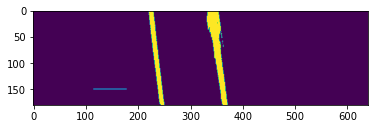

In [178]:
def plot_canny_histogram(self, bins, hist):

  clr = (255,0,0) # color

  # Create an output image to draw on and  visualize the result
  self.im_hist = np.dstack((self.im_bwarped,
                            self.im_bwarped, self.im_bwarped)) * 255

  # Visualize histogram
  plotx = np.repeat(bins, 2)[1:-1]
  ploty = np.repeat(hist[:,0], 2)

  # Draw polyline on image
  line = np.asarray(tuple(zip(plotx, self.im_h - ploty)), np.int32)
  self.im_hist = cv2.polylines(self.im_hist, [line], False, clr, thickness=3)

def get_canny_histogram(self, dev_mode = False):

  n_bins = 21 # choose an odd number
  bins = np.linspace(start = 0, stop = self.im_w, num = 21).astype(int)

  hist = np.empty(shape = (0, 2)).astype(int)
  for x1, x2 in zip(bins[:-1], bins[1:]):
    nx = self.im_bwarped[self.hist_y0:, x1:x2].nonzero()[0]
    cx = x1 + np.mean(nx).astype(int) if len(nx) > 0 else 0
    hist = np.append(hist, [[len(nx), cx]], axis=0) 


  # plot histogram
  if dev_mode:
    plot_canny_histogram(self, bins, hist)


  # get histogram peaks
  l_peak  = np.max(hist[:n_bins//2, 0]) # peak size px
  r_peak = np.max(hist[n_bins//2:, 0])

  lx_peak = hist[np.argmax(hist[:n_bins//2, 0]), 1]
  rx_peak = hist[n_bins//2 + np.argmax(hist[n_bins//2:, 0]), 1]

  # detected road width 
  det_roadx_px = rx_peak - lx_peak 

  # no valid peak (no line)
  if max(l_peak, r_peak) < self.hist_min:
    print(f'l_peak: {l_peak}, r_peak: {r_peak}, hist_min: {self.hist_min}')
    self.road_det = False
    return

  # one valid peak (one line)
  if ((l_peak >= self.hist_min) ^ (r_peak >= self.hist_min)):

    if l_peak >= r_peak: # keep max peak
      self.ll.xbase = lx_peak
    else:
      self.rl.xbase = rx_peak

    return

  # road width outside tolerance
  if abs(det_roadx_px - self.roadx_px) > self.roadx_tol_px:

    if l_peak >= r_peak: # keep max peak
      self.ll.xbase = lx_peak
    else:
      self.rl.xbase = rx_peak

    return
    
  # else two valid peaks (two lines)
  self.ll.xbase, self.rl.xbase = lx_peak, rx_peak

print(rd.im_bwarped.shape)
rd.get_canny_histogram(dev_mode = True)
plt.imshow(rd.im_bwarped)
plt.plot([116, 176], [150, 150])

In [179]:
def plot_histogram(self, hist):

  clr = (255,0,0) # color

  # Create an output image to draw on and  visualize the result
  self.im_hist = np.dstack((self.im_bwarped,
                            self.im_bwarped, self.im_bwarped)) * 255

  # Visualize histogram
  plotx = np.linspace(0, self.im_w - 1, self.im_w)

  # Draw polyline on image
  line = np.asarray(tuple(zip(plotx, self.im_h - hist)), np.int32)
  self.im_hist = cv2.polylines(self.im_hist, [line], False, clr, thickness=3)

def get_histogram(self, dev_mode = False):

  self.road_det = True
    
  self.ll.xbase, self.rl.xbase = None, None # reset

  # calculate histogram
  hist = np.sum(self.im_bwarped[self.hist_y0:,:], axis=0) 

  # plot histogram
  if dev_mode:
    plot_histogram(self, hist)
      
  # get histogram peaks
  l_peak  = np.max(hist[:self.im_cx]) # peak size px
  r_peak = np.max(hist[self.im_cx:])

  lx_peak  = np.argmax(hist[:self.im_cx])
  rx_peak = np.argmax(hist[self.im_cx:]) + self.im_cx

  # detected road width 
  det_roadx_px = rx_peak - lx_peak 
  
  # no valid peak (no line)
  if max(l_peak, r_peak) < self.hist_min:
    print(f'l_peak: {l_peak}, r_peak: {r_peak}, hist_min: {self.hist_min}')
    self.road_det = False
    return

  # one valid peak (one line)
  if ((l_peak >= self.hist_min) ^ (r_peak >= self.hist_min)):

    if l_peak >= r_peak: # keep max peak
      self.ll.xbase = lx_peak
    else:
      self.rl.xbase = rx_peak

    return

  # road width outside tolerance
  if abs(det_roadx_px - self.roadx_px) > self.roadx_tol_px:

    if l_peak >= r_peak: # keep max peak
      self.ll.xbase = lx_peak
    else:
      self.rl.xbase = rx_peak

    return
    
  # else two valid peaks (two lines)
  self.ll.xbase, self.rl.xbase = lx_peak, rx_peak

### Plot Window Search Result

In [180]:
def plot_window_search(self):

  # create an output image to draw on and  visualize the result
  self.im_win = np.dstack((self.im_bwarped,
                            self.im_bwarped, self.im_bwarped)) * 255
  
  win_clr = (0,255,0) # window color
  ln_clr = (0,0,255) # line color
  px_clr = (255, 0, 0)

  for ln in [self.ll, self.rl]:

    if ln.fit is None: continue

    # color pixels
    indices = (ln.winpx[:,1], ln.winpx[:,0])
    rd.im_win[indices] = px_clr

    # Draw the windows on the visualization image
    for (p1, p2) in ln.winco:
      cv2.rectangle(self.im_win, p1, p2, win_clr, 2)
        
    # generate x and y values for plotting
    ymin = ln.winpx[:,1].min()
    ymax = ln.winpx[:,1].max()
    yrange = ymax - ymin

    ploty = np.linspace(ymin, ymax, yrange)
        
    line_fitx = np.polyval(ln.fit, ploty)

    # draw polyline on image
    line = np.asarray(tuple(zip(line_fitx, ploty)), np.int32)
    cv2.polylines(self.im_win, [line], False, ln_clr, thickness=3)

### Sliding Window

In [181]:
def window_search(self, ln, dev_mode = False):

  # skip if no line base found
  if ln.xbase is None:
    ln.fit, ln.grad = None, None
    return 

  # all x- and y-coordinates
  all_x = all_y = []
  
  # initial window coordinates (x1, y1), (x2, y2) := (top-left),(bottom-right)
  pred_cx = ln.xbase # initial window center pos in x
  prev_cx = None # previous window center pos in x
  y2 = self.im_h
  y1 = y2 - self.win_h
  x1 = pred_cx - self.win_w // 2
  x2 = pred_cx + self.win_w // 2

  # clip window to image borders
  x1, x2 = np.clip([x1, x2], 0, self.im_w)
  y1, y2 = np.clip([y1, y2], 0, self.im_h)

  dy = []

  # step through the windows one by one
  for n in range(self.win_num):
      
    # nonzero x-y-coordinates
    y, x = self.im_bwarped[y1:y2, x1:x2].nonzero()
      
    # break if window not valid
    if len(x) > self.win_pixmax or len(x) < self.win_pixmin:
      print(f'Win Search stopped: len x: {len(x)}, win_pixmin: {self.win_pixmin}')
      break
    
    # shift from window coordinates to image coordinates
    y += y1
    x += x1
    
    # all pixels
    all_x = [*all_x, *x]
    all_y = [*all_y, *y]

    if dev_mode:

      # store pixels
      xy = np.stack((x,y), axis = 1)
      ln.winpx = xy if ln.winpx is None else np.concatenate((ln.winpx, xy), axis = 0)

      # store window
      if ln.winco is None: ln.winco = [[(x1,y1), (x2,y2)]]
      else: ln.winco.append([(x1,y1), (x2,y2)])


    # calc next window position
    updated_cx = int(np.mean(x))
    updated_cy = int(np.mean(y))

    '''
    in sharp curves, the camera only sees the outer line
    if there is only one line visible (single_line:=True) we calculate the gradient m 
    if m < 0 -> right curve -> camera only sees left line
    if m > 0 -> left curve -> camera only sees right line
    '''

    if prev_cx is None:
      m = np.polyfit(x, y, 1)[0]
      dx = 0 # -np.sign(m) * np.ptp(x)
    else:
      dx = updated_cx - prev_cx


    dy = np.ptp(y) # prediction along vector in y

    pred_cx = updated_cx + int(dx) # prediction along vector in x
    prev_cx = updated_cx # previous


    # update window position
    y2 -= dy
    y1 -= dy
    x1 = pred_cx - self.win_w // 2
    x2 = pred_cx + self.win_w // 2
      
    # clip window to image borders
    x1, x2 = np.clip([x1, x2], 0, self.im_w)
    y1, y2 = np.clip([y1, y2], 0, self.im_h)

  if len(all_x) > self.win_pixmin:
    # fit a 2nd order polynomial
    ln.fit = np.polyfit(all_y, all_x, 2)

    # fit a 1st order polynomial 
    ln.grad = np.polyfit(all_x, all_y, 1)[0] # x y switched

  else:
    ln.fit, ln.grad = None, None



def run_window_search(self, dev_mode = False):

  self.road_det = True

  # clear previous results
  for ln in self.lns:
    ln.set_ln_vars()

  # get window base position
  if self.apply_canny and self.apply_range:
    self.get_histogram(dev_mode)
  elif self.apply_canny:
    self.get_canny_histogram(dev_mode)

  if not self.road_det:
    print('No valid starting point found in histogram.')
    return

  # run window search
  for ln in [self.ll, self.rl]:
    window_search(self, ln, dev_mode)
  
  if (self.ll.fit is None and self.rl.fit is None):
    self.road_det = False
  
  if self.road_det and dev_mode:
    self.plot_window_search()




## Validate Lane Update

### Generate Validation Image

In [183]:
def get_validation_image(self):
    ''' 
    generates semantic map
    background (0), left_line(1), left_line_border(2), right_line(3), right_line_border(4)
    '''

    # Generate a validation image
    im_val = np.zeros((self.im_h, self.im_w, 3), dtype = np.uint8)


    for ln in self.lns:

      if ln.fit is None:
        continue

      # Generate x and y values for plotting
      ploty = np.linspace(0, self.im_h, self.im_h)

      line_fitx = np.polyval(ln.fit, ploty)
      # Draw polyline on image
      line = np.asarray(tuple(zip(line_fitx, ploty)), np.int32)
      # Plot border
      cv2.polylines(im_val, [line], False, (0, ln.bd_id, 0), thickness=self.lnx_tol_px)
      # Plot ideal lane line
      cv2.polylines(im_val, [line], False, (0, ln.ln_id, 0), thickness=self.lnx_px)

    self.im_val = np.max(im_val, axis = -1)
    

def get_dynamic_mask(self):

  # mask out background in preprocessing
  self.dyn_mask = np.zeros_like(self.im_val)

  for ln in self.lns:

    if ln.r_total > self.rmin:
      self.dyn_mask[(self.im_val == ln.bd_id) | (self.im_val == ln.ln_id)] = 1

def plot_quality_rating(self):

    self.im_rating = self.im_match + self.im_val
    self.im_rating += self.im_bwarped


### Calculate Quality Rating

In [184]:
def validate_lane_update(self, dev_mode = False):    
  
  for ln in self.lns:
    ln.set_ln_rating () # rest rating

  # loginfo
  msg = "r_iou x r_len x r_border = r_total \n" 
  tpl = "{}:  {:0.2f} x {:0.2f} x {:0.2f} = {:0.2f} \n"

  # get validation image
  self.get_validation_image()
  
  self.im_match = np.multiply(self.im_bwarped, self.im_val)

  for s, ln in zip(['Left', 'Right'], self.lns):
    
    if ln.fit is None: continue

    ln_px = (self.im_val == ln.ln_id).sum() # total line pixels
    bd_px = (self.im_val == ln.bd_id).sum() # total border pixels

    ln_match = (self.im_match == ln.ln_id).sum() # matching line pixels
    bd_match = (self.im_match == ln.bd_id).sum() # matching border pixels

    # line matching factor := 1.0
    # if predicted line identical with filtered line
    ln.r_iou = ln_match /ln_px if ln_px != 0 else 0

    # border matching factor := 1.0 
    # if no artifacts in predicted border
    ln.r_border = 1 - (bd_match/bd_px) if bd_px != 0 else 0


    # length factor := 1.0 
    # if number of pixels > number of pixel in a straight line
    ln.r_len = np.clip(ln_match / self.ln_pixmax, 0, 1)
  
    # weights
    ln.r_total =  (self.w_iou * ln.r_iou + self.w_len * ln.r_len + \
                   self.w_border * ln.r_border)
    
    # loginfo
    msg = msg + tpl.format(s, ln.r_iou, ln.r_len, ln.r_border, ln.r_total)

  # check results
  if (self.ll.r_total < self.rmin and self.rl.r_total < self.rmin):
    self.road_det = False
    self.rl.set_ln_vars() # reset lines
    self.ll.set_ln_vars()
    return
  
  for ln in self.lns:
    if ln.r_total < self.rmin:
      self.im_val[(self.im_val == ln.ln_id) | (self.im_val == ln.bd_id)] = 0
      ln.set_ln_vars() # reset 



  if dev_mode:
    print(msg, dev_mode)
    self.plot_quality_rating()


## Polyfit Search

In [185]:
def plot_polysearch(self):

  # Create an output image to draw on and  visualize the result
  self.im_polyfit = np.dstack((self.im_bwarped, self.im_bwarped,
                            self.im_bwarped)) * 255
  
  ln_clr = (0,0,255) # line color

  for ln in self.lns:

    if (ln.polypix is None or ln.fit is None): continue

    # generate x and y values for plotting
    ymin = ln.polypix[:,1].min()
    ymax = ln.polypix[:,1].max()
    yrange = ymax - ymin

    ploty = np.linspace(ymin, ymax, yrange)

    line_fitx = np.polyval(ln.fit, ploty)

    # Draw polyline on image
    line = np.asarray(tuple(zip(line_fitx, ploty)), np.int32)
    cv2.polylines(self.im_polyfit, [line], False, ln_clr, thickness=3)

In [186]:
def polyfit_search(self, dev_mode=False):
    
    tmp_im = self.im_bwarped * self.im_val
    
    for ln in self.lns:

        if ln.fit is None: continue
        
        all_y, all_x =  np.where((tmp_im == ln.ln_id) | (tmp_im == ln.bd_id))

        if len(all_x) < self.poly_minpix: continue
        
        # weight polyfit (1/x)
        w = np.zeros_like(all_y, dtype = np.float16) 

        l = np.linspace(0, all_y.size, 5, dtype = np.int16)

        for i in range(0, 4):
          w[l[i]:l[i+1]] = 1/(5-i)

        # Fit a second order polynomial to each
        ln.fit = np.polyfit(all_y, all_x, self.nth_order, w = w)

        # Fit a first order polynomial and save gradient
        ln.grad = np.polyfit(all_x, all_y, 1)[0]

        # store pixels
        if dev_mode:
          ln.polypix = np.stack((all_x, all_y), axis = 1)

    if (self.ll.fit is None and self.rl.fit is None):
      self.road_det = False

    if dev_mode and self.road_det:
      plot_polysearch(self)

## Lane Line Detection Pipeline

In [195]:
def run_road_detection_(self, im, dev_mode = False):
  '''   road_det is set True at beginning of window search
        and returned as false if window search failes

        road_det has to be true at beginning of polyfit search
        and returned as false if polyfit search failes

  '''
  pass


## Controling

In [188]:
def calc_steering_angle(self, dev_mode = False):
    
    if  self.ofst_m is not None:
         self.prev_ofst_m = self.ofst_m
    
    #left
    if self.ll.r_total >= self.rl.r_total:
        road_cx = np.polyval(self.ll.fit, self.im_h) + self.half_roadx_px
        theta = int(np.rad2deg(np.arctan(self.ll.grad)))
    
    # right
    else: 
        road_cx = np.polyval(self.rl.fit, self.im_h) - self.half_roadx_px
        theta = int(np.rad2deg(np.arctan(self.rl.grad)))
    
    if theta <= 0: 
        theta += 90
    else:
        theta -= 90
    
    ofst_px = self.im_cx - road_cx # offset to right (-) offset to left (+)
    self.ofst_m = ofst_px * self.px2m_x
    
    # PD controller
    # e.g. -0.2 m (offset to the right) * 110 (kP) = - 22° steering to the left
    p_steer = self.ofst_m * self.kP 

    # e.g. -0.1 m (movement to the right) * 50 (kD) = - 5° additional steering to the left
    if  self.prev_ofst_m is not None:
        d_steer = (self.prev_ofst_m - self.ofst_m) * self.kD
    else:
        d_steer = 0

    steer = d_steer + p_steer # steering angle
    
    steer = np.clip(steer, self.steer_min, self.steer_max)
    
    if dev_mode:
        print(f"Offset {int(self.ofst_m * 100)} cm, Steering angle {int(steer)}°, Gradient {int(theta)}°")
        

In [189]:
def get_ackermann_angles(self, deg = None):
  ''' calculate left and right steering angle in deg from
      inner steering angle
      see: https://www.xarg.org/book/kinematics/ackerman-steering/ '''
  
  rad = np.deg2rad(deg)
  l = np.rad2deg(np.arctan((2 * self.wb_m * np.sin(rad)) /
                           (2 * self.wb_m * np.cos(rad) +
                            self.xt_m * np.sin(rad))))

  r = np.rad2deg(np.arctan((2 * self.wb_m * np.sin(rad)) /
                           (2 * self.wb_m * np.cos(rad) -
                            self.xt_m * np.sin(rad))))
  
  return l, r

## Test Pipeline

### Setup

In [190]:
class RoadDetection():
  def __init__(self, fpath = None):
    decl_config(self)
    decl_variables(self)
    #load_config(self, fpath)
    show_config(self)
    #save_config(self, fpath)

  def generate_hood_mask(self, im):
    generate_hood_mask(self, im)

  def generate_canny_mask(self, im):
    generate_canny_mask(self, im)

  def prep_input(self, im = None):
    prep_input(self, im)

  def calib_geometry(self, geo_im):
    calib_geometry(self, geo_im)

  def decl_config(self):
    decl_config(self)

  def decl_variables(self):
    decl_variables(self)

  def load_config(self, fpath):
    load_config(self, fpath)

  def show_config(self):
    show_config(self)

  def save_config(self, fpath):
    save_config(self, fpath)

  def set_image(self, im):
    set_image(self, im)

  def preprocess_image(self):
    preprocess_image(self)

  def apply_canny_thresh(self, im = None):
    apply_canny_thresh(self, im)

  def apply_hls_thresh(self, im = None):
    apply_hls_thresh(self, im)

  def get_histogram(self, dev_mode = False):
    get_histogram(self, dev_mode)
  
  def get_canny_histogram(self, dev_mode = False):
    get_canny_histogram(self, dev_mode)

  def window_search(self, im, dev_mode = False):
    window_search(self, im, dev_mode)

  def run_window_search(self, dev_mode = False):
    run_window_search(self, dev_mode)
  
  def plot_window_search(self):
    plot_window_search(self)
  
  def get_validation_image(self):
    get_validation_image(self)
  
  def get_dynamic_mask(self):
    get_dynamic_mask(self)
  
  def validate_lane_update(self, dev_mode = False):
    validate_lane_update(self, dev_mode)
  
  def plot_quality_rating(self):
    plot_quality_rating(self)
  
  def polyfit_search(self, dev_mode = False):
    polyfit_search(self, dev_mode)

  def plot_polysearch(self):
    plot_polysearch(self)

  def run_road_detection(self, im, dev_mode = False):
    run_road_detection(self, im, dev_mode)
  
  def set_images(self):
    set_images(self)
  
  def calc_steering_angle(self, dev_mode = False):
    calc_steering_angle(self, dev_mode)
  
  def visualize_gt(self, gt_deg, pred_deg = None, ofst_px = None):
    visualize_gt(self, gt_deg, pred_deg, ofst_px)
  
  def plot_gt(self, im, gt_rad, pred_rad = None, ofst_px = None):
    plot_gt(self, im, gt_rad, pred_rad, ofst_px)

fpath = 'test_config.yaml'

rd = RoadDetection(fpath)
rd.generate_hood_mask(geo_im)
rd.calib_geometry(geo_im)
rd.generate_canny_mask(geo_im)
clear_output()


In [191]:
''' wheels '''
rd.dw_m = 0.097 # wheel diameter [m]
rd.xw_m = 0.04 # wheel width [m]
rd.xt_m = 0.27 # track width [m]
rd.wb_m = 0.36 # wheelbase [m]
rd.dw = int(rd.dw_m * rd.m2px_x) # wheel diameter [pixel]
rd.xw = int(rd.xw_m * rd.m2px_x) # wheel width [pixel]
rd.xt = int(rd.xt_m * rd.m2px_x) # track width [pixel]
rd.wb = int(rd.wb_m * rd.m2px_x) # wheelbase [pixel]

''' camera '''
rd.cam_ofst_m = -32.5e-3 # RealSense D435i -32.5 mm offset in x
rd.cam_ofst_px = int(rd.cam_ofst_m * rd.m2px_x)

''' road geometry '''
rd.lnx_m = 0.05
rd.roadx_m = 0.75
rd.lnx_px = int(rd.lnx_m * rd.m2px_x)
rd.roadx_px = int(rd.roadx_m * rd.m2px_x)
rd.roadx_tol_per = 0.2
rd.roadx_tol_px = rd.roadx_px * rd.roadx_tol_per
rd.rlx_m =  (rd.roadx_m + rd.lnx_m) / 2 # right  line pos x [meters]
rd.llx_m =  -rd.rlx_m # left  line pos x [meters]
rd.rlx = int(rd.im_cx + rd.rlx_m * rd.m2px_x) # right line pos x
rd.llx = int(rd.im_cx + rd.llx_m * rd.m2px_x) # left  line pos x

''' config preprocessing '''
rd.apply_range = False
rd.apply_canny = True
rd.hls_tmin = 90 # minimum lightness
rd.hls_tmax = 255 
rd.canny_tmin = 70
rd.canny_tmax = 255
rd.apply_dmask = False
rd.prp_pxmax = rd.lnx_px * rd.im_h * 4
rd.prp_pxmin = rd.lnx_px * rd.im_h // 4

''' config window '''
 # ratio between fill and contour only ~ 5
rd.hist_frac = 0.1
rd.hist_y0 = int(rd.im_h * (1.0 - rd.hist_frac))
rd.hist_min = 5
rd.win_num = 8 
rd.win_w = 60
rd.win_h = rd.im_h // rd.win_num
rd.win_pixmin = rd.lnx_px * rd.win_w // 5 // 4
rd.win_pixmax = rd.lnx_px * rd.win_w 

''' validation '''
rd.ll.ln_id = 1 # segmenation line id
rd.ll.bd_id = 2 # segmenation border id
rd.rl.ln_id = 3
rd.rl.bd_id = 4

rd.w_border = 0.2 # weight border rating
rd.w_iou = 0.6 # weight iou rating
rd.w_len = 0.2 # weight length rating
rd.rmin = 0.0 # 0.05 # min required rating

rd.lnx_tol_per = 3.0
rd.lnx_tol_px = int(rd.lnx_px * rd.lnx_tol_per)

rd.ln_pixmax = rd.im_h * rd.lnx_px

''' polyfit search '''
rd.poly_minpix = (rd.lnx_px * rd.im_h) // 8 // 5
rd.nth_order = 2
rd.do_polysearch = True

''' control '''
rd.half_roadx_px = (rd.roadx_px + rd.lnx_px) // 2
rd.kD = 110
rd.kP = 50
rd.steer_max =  30 
rd.steer_min = -30

''' groud truth viz '''
x1 = rd.im_cx - rd.half_roadx_px - rd.lnx_tol_px // 2
x2 = rd.im_cx - rd.half_roadx_px + rd.lnx_tol_px // 2
x3 = rd.im_cx
x4 = rd.im_cx + rd.half_roadx_px - rd.lnx_tol_px // 2
x5 = rd.im_cx + rd.half_roadx_px + rd.lnx_tol_px // 2
y  = rd.im_h + 10

rd.lnx_mark = np.array((x1, x2, x3, x4, x5)) + rd.cam_ofst_px
rd.lny_mark = np.repeat(y, 5)

''' blindspot'''
# sw:= starting point (top left corner) l/r wheel
# cw:= center l/r wheel

rd.xref_ofst_m = 0.0 # offset reference point to front axle [m]
rd.yref_ofst_m = 0.55

rd.xref_ofst = int(rd.xref_ofst_m * rd.m2px_x)
rd.yref_ofst = int(rd.yref_ofst_m * rd.m2px_x)

xs_l = rd.xref - (rd.xt + rd.xw) // 2 + rd.cam_ofst_px
xs_r = rd.xref + (rd.xt - rd.xw) // 2 + rd.cam_ofst_px

ys_l = ys_r = rd.yref + rd.yref_ofst 

rd.sw_l = (xs_l, ys_l) # starting point
rd.sw_r = (xs_r, ys_r)

rd.cw_l = (xs_l + rd.xw // 2, ys_l + rd.dw // 2) # center
rd.cw_r = (xs_r + rd.xw // 2, ys_r + rd.dw // 2) 

rd.axle_c = (rd.xref + rd.xref_ofst + rd.cam_ofst_px, rd.cw_l[1]) # center front axle


## Visualize Results

In [194]:
''' Test Pipeline '''
nrows = 2
ncols = 4
fsize = (4 * ncols, 2 * nrows)

def initial_step(dev_mode = False):

  rd.apply_canny, rd.apply_range, apply_dmask = True, False, False

  rd.preprocess_image()

  rd.run_window_search(dev_mode)

  rd.validate_lane_update()

  rd.get_dynamic_mask()

rd.apply_dmask = False
rd.road_det = False

for i, (fname, rad) in enumerate(zip(df['fname'], df['steering_angle'])):

  if i == 60: break

  # setup plot
  fig, ax = plt.subplots(nrows, ncols, figsize = fsize)
  fig.tight_layout()

  # load image
  fpath = os.path.join(im_dir, fname)
  im = np.array(cv2.imread(fpath))
  rd.set_image(im)

  # preprocessing
  rd.apply_canny, rd.apply_range, rd.apply_dmask = True, False, False
  rd.preprocess_image()

  # run sliding window
  rd.run_window_search(dev_mode = True)

  ax[0,0].imshow(rd.im_prep)
  ax[0,1].imshow(rd.im_bwarped, cmap = 'gray')
  if rd.road_det:
    ax[0,2].imshow(rd.im_win)

    rd.validate_lane_update(dev_mode = True)
    rd.get_dynamic_mask()


    ax[0,3].imshow(rd.im_val)

    rd.apply_canny, rd.apply_range, rd.apply_dmask = True, True, True
    rd.preprocess_image()

    ax[1,0].imshow(rd.im_bwarped, cmap = 'gray')

    # run sliding window
    rd.run_window_search(dev_mode = True)

    ax[1,1].imshow(rd.im_win)

    rd.validate_lane_update(dev_mode = True)
    rd.get_dynamic_mask()

    rd.polyfit_search(dev_mode = True)

    if rd.road_det:
      ax[1,2].imshow(rd.im_polyfit)

  for axes in ax.flatten() :
      axes.axis('off')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.